In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


In [ ]:
#pwd

In [ ]:
corr_df = pd.read_csv('responses.csv')
corr_df.head(5)

In [ ]:
print(corr_df.shape)
print(corr_df['id'].isna().sum())

In [ ]:
corr_df.describe()

In [ ]:
corr_df.boxplot(column='corr')

In [ ]:
#image_dir = Path('images')
#filepaths = pd.Series(list(image_dir.glob(r'**/*.png')), name='Filepath').astype(str)
#filepaths

In [ ]:
# Merging all the columns in a single CSV to reduce the overhead

imgpath_df = pd.DataFrame(columns=['id', 'corr'])
imgpath_df['id'] = corr_df['id']
imgpath_df['corr'] = corr_df['corr']

imgpath_df['filepath'] = 'images/' + imgpath_df['id'].astype(str) + '.png'

print(imgpath_df)

In [ ]:
# Trying with some samples
#img_df = merged_df.sample(10000, random_state=1).reset_index(drop=True)
#img_df

img_df = imgpath_df.sample(150000, random_state=1).reset_index(drop=True)

In [ ]:
train_df, test_df = train_test_split(img_df, test_size=0.2, shuffle=True, random_state=1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='corr',
    target_size=(150, 150),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=128,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='corr',
    target_size=(150, 150),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=128,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='corr',
    target_size=(150, 150),
    color_mode='grayscale',
    class_mode='raw',
    batch_size=128,
    shuffle=False
)

In [ ]:
# import cv2
# img = cv2.imread('images/aaacpaqd.png')
# img.shape

In [62]:
inputs = tf.keras.Input(shape=(150, 150, 1))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
#x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='mse'
)

history = model.fit(
    train_images,
    validation_data=val_images, 
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        )
    ]
)

750/750 ━━━━━━━━━━━━━━━━━━━━ 74s 99ms/step - loss: 0.0568 - val_loss: 0.0506
Epoch 53/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 73s 98ms/step - loss: 0.0565 - val_loss: 0.0557
Epoch 54/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 73s 98ms/step - loss: 0.0562 - val_loss: 0.0540
Epoch 55/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 73s 98ms/step - loss: 0.0565 - val_loss: 0.0512
Epoch 56/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 73s 98ms/step - loss: 0.0558 - val_loss: 0.0503
Epoch 57/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 73s 98ms/step - loss: 0.0554 - val_loss: 0.0505
Epoch 58/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 73s 98ms/step - loss: 0.0556 - val_loss: 0.0564
Epoch 59/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 73s 98ms/step - loss: 0.0554 - val_loss: 0.0493
Epoch 60/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 73s 98ms/step - loss: 0.0551 - val_loss: 0.0503
Epoch 61/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 73s 97ms/step - loss: 0.0547 - val_loss: 0.0517
Epoch 62/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 73s 98ms/step - loss: 0.0544 - val_loss: 0.0518
Epoch 63/100
750/750 ━━

In [63]:
from sklearn.metrics import r2_score
predicted_ages = np.squeeze(model.predict(test_images))
true_ages = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("Test RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_ages, predicted_ages)
print("Test R2 Score: {:.5f}".format(r2))

235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step
Test RMSE: 0.21380
Test R2 Score: 0.76530


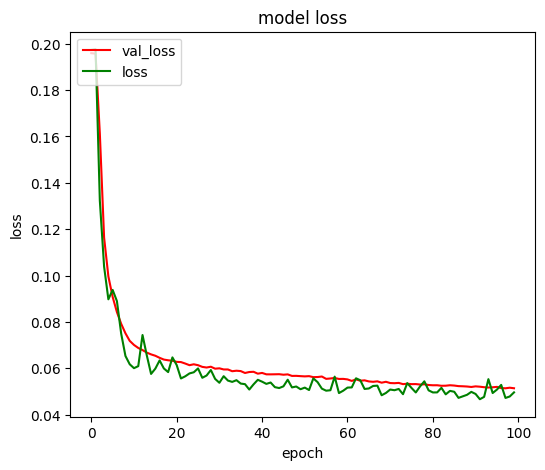

In [64]:
plt.figure(figsize=(6, 5))
# training loss
plt.plot(history.history['loss'], color='r')
#validation loss
plt.plot(history.history['val_loss'], color='g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='upper left')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Predicted result: [0.6809768]
Actual Result: [0.72528782]


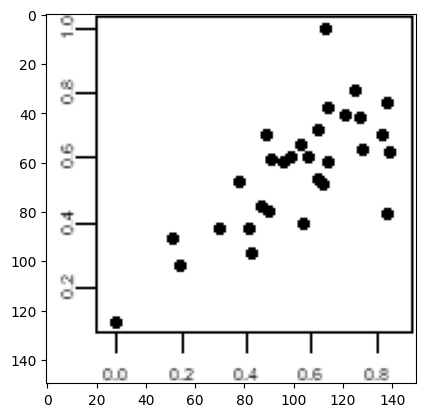

In [77]:
test_image_path = 'images/emrjcoap.png'
test_image = tf.keras.preprocessing.image.load_img(test_image_path, target_size=(150, 150), color_mode='grayscale')
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image / 255.0 
prediction = model.predict(test_image)
test_image = np.squeeze(test_image, axis=0)  # Remove the batch dimension
test_image = np.squeeze(test_image, axis=-1)  
plt.imshow(test_image,cmap='gray')


print("Predicted result:", prediction[0]) # Predicted 

image_id = test_image_path.split('/')[-1].split('.')[0]
score = corr_df.loc[corr_df['id'] == image_id, 'corr'].values
print("Actual Result:", score)
